In [1]:
import os
import torch

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import albumentations as A
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

device = "cuda" if torch.cuda.is_available() else "cpu"

# Getting data

In [2]:
!gdown https://drive.google.com/u/0/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s
From (redirected): https://drive.google.com/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s&confirm=t&uuid=0c6382b3-5f35-45c2-827b-966d0ca7eb85
To: /content/maps.zip
100% 252M/252M [00:02<00:00, 103MB/s]


In [3]:
!7z x maps.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 251592154 bytes (240 MiB)

Extracting archive: maps.zip
 93% 4096 Open              --
Path = maps.zip
Type = zip
Physical Size = 251592154

  0%      6% 302         12% 602 - maps/train/1090.jpg                               18% 887 - __MACOSX/maps/train/._106.jpg                                         24% 1171 - __MACOSX/maps/train/._862.jpg                                          29% 1445 - __MACOSX/maps/train/._24.jpg

In [4]:
!ls maps

train  val


# Dataloaders

In [5]:
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path)
        width, height = image.size
        half_width = width // 2
        left_image = image.crop((0, 0, half_width, height))
        right_image = image.crop((half_width, 0, width, height))

        if self.transform:
            transformed = self.transform(image=np.array(left_image), image0=np.array(right_image))
            left_image, right_image = transformed['image'], transformed['image0']

        return left_image, right_image

In [6]:
# [-1, 1]
def normalize(x, **kwargs):
    return ((x / 127.5) - 1).astype(np.float32)

# [-1, 1]
def denormalize(x, **kwargs):
    # return torch.clamp((x + 1) * 255 / 2, 0, 255).to(torch.uint8)
    return torch.clamp(((x * 255.0) + 255) / 2, 0, 255).to(torch.uint8)

# [0, 1]
# def normalize(x, **kwargs):
#     return (x / 255.0).astype(np.float32)

# [0, 1]
# def denormalize(x, **kwargs):
#     return torch.clamp(x * 255, 0, 255).to(torch.uint8)

# https://albumentations.ai/docs/api_reference/augmentations/
transform = A.Compose([
    # A.ColorJitter(p=0.3),
    A.Resize(256, 256),
    # A.Rotate(limit=40),
    A.Lambda(image=normalize),
    ToTensorV2(),
], additional_targets={'image0': 'image'})

In [7]:
train_path = 'maps/train'
valid_path = 'maps/val'
train_batch_size = 32
valid_batch_size = 2

dataset_train = ImageFolderDataset(train_path, transform=transform)
dataset_valid = ImageFolderDataset(valid_path, transform=transform)

dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=False)
dataloader_vaild = DataLoader(dataset_valid, batch_size=valid_batch_size, shuffle=False)

In [67]:
def show_images(left_images, right_images, title=None):
    fig, axes = plt.subplots(len(left_images), 2, figsize=(5, 5))
    for i, (left_img, right_img) in enumerate(zip(left_images, right_images)):
        left_img = left_img.permute(1, 2, 0)
        right_img = right_img.permute(1, 2, 0)
        axes[i, 0].imshow(left_img)
        axes[i, 1].imshow(right_img)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    if title is not None:
        fig.suptitle(f"{title}")
    plt.show()

torch.Size([2, 3, 256, 256])


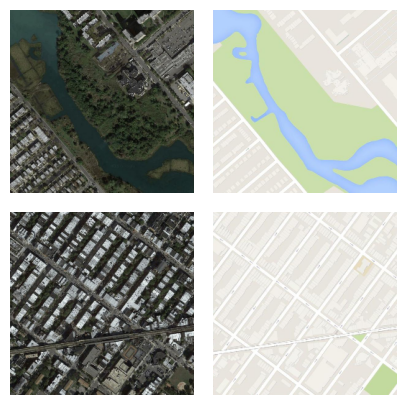

In [9]:
images = next(iter(dataloader_vaild))
left_images, right_images = images
print(left_images.shape)
left_images = denormalize(left_images)
right_images = denormalize(right_images)
show_images(left_images, right_images)

# Architecture

In [52]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [53]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.residuals = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )

        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.downsample(x)
        x = self.residuals(x)
        x = self.upsample(x)
        return x

In [54]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            # Input is 6 x 256 x 256 (real image + generated image)
            nn.Conv2d(6, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, input):
        return self.layers(input)

# Loss function

In [55]:
def style_loss(gen, target):
    gen_gram = gram_matrix(gen)
    target_gram = gram_matrix(target)
    return F.mse_loss(gen_gram, target_gram)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (c * h * w)

def generator_loss(disc_generated_output, gen_output, target, style_weight=1e5):
    gen_gan_loss = F.binary_cross_entropy(disc_generated_output, torch.ones_like(disc_generated_output))
    gen_l1_loss = F.l1_loss(gen_output, target)
    gen_style_loss = style_loss(gen_output, target)
    return gen_gan_loss + gen_l1_loss + style_weight * gen_style_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = F.binary_cross_entropy(disc_real_output, torch.ones_like(disc_real_output))
    generated_loss = F.binary_cross_entropy(disc_generated_output, torch.zeros_like(disc_generated_output))
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Trening

In [56]:
def save_models(generator, discriminator, path='models'):
    torch.save(generator.state_dict(), f'{path}/geogan_generator.pth')
    torch.save(discriminator.state_dict(), f'{path}/geogan_discriminatoar.pth')

In [64]:
G = Generator().to(device)
D = Discriminator().to(device)
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [65]:
epochs = 100
dataloader_vaild_iter = iter(dataloader_vaild)

ok
ok2


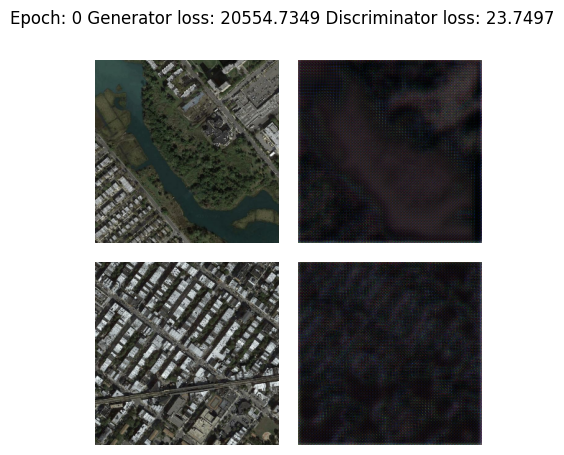

ok
ok2


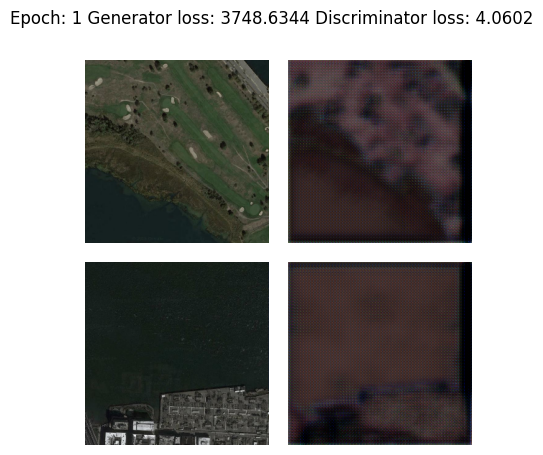

ok
ok2


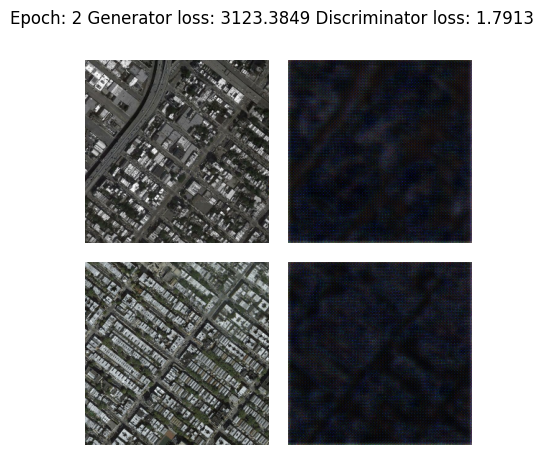

KeyboardInterrupt: 

In [66]:
for i in range(epochs):
  G_loss_acc = 0.0
  D_loss_acc = 0.0
  G.train()
  D.train()

  for batch_idx, (left_images, right_images) in enumerate(dataloader_train):
      left_images = left_images.to(device)
      right_images = right_images.to(device)

      right_fake = G(left_images)

      right_fake_detached = right_fake.detach()

      G_loss = generator_loss(D(torch.cat((left_images, right_fake), dim=1)), right_fake, right_images)

      G_optimizer.zero_grad()
      G_loss.backward()
      G_optimizer.step()

      real = torch.cat((left_images, right_images), dim=1)
      fake = torch.cat((left_images, right_fake_detached), dim=1)
      D_loss = discriminator_loss(D(real), D(fake))

      D_optimizer.zero_grad()
      D_loss.backward()
      D_optimizer.step()

      G_loss_acc += G_loss.item() * len(left_images)
      D_loss_acc += D_loss.item() * len(left_images)

  # if epochs % 10 == 0:
  if True:
    G.eval()
    with torch.no_grad():
      images = next(dataloader_vaild_iter)
      left_images, right_images = images
      right_fake = G(left_images.to(device))

      left_images = left_images.cpu()
      right_fake = right_fake.cpu()

      left_images = denormalize(left_images)
      right_fake = denormalize(right_fake)
      show_images(
        left_images,
        right_fake,
        title= f"Epoch: {i} Generator loss: {G_loss_acc / len(dataloader_train) :.4f} Discriminator loss: {D_loss_acc / len(dataloader_train) :.4f}"
        )

In [ ]:
  save_models(G, D)

Mon Jun  3 19:31:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              33W /  70W |  14487MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--